## Applying Transfer Learning for Facial Recognition    

In [1]:
import pandas as pd
from sklearn.datasets import fetch_lfw_people

In [2]:
faces = fetch_lfw_people(min_faces_per_person=100, slice_=None, resize=1.0, color=True)
faces.images = faces.images[:, 60:188, 60:188]
faces.data = faces.images.reshape((faces.images.shape[0], faces.images.shape[1]*faces.images.shape[2], faces.images.shape[3]))

class_count = len(faces.target_names)

print(faces.target_names)
print(faces.images.shape)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 128, 128, 3)


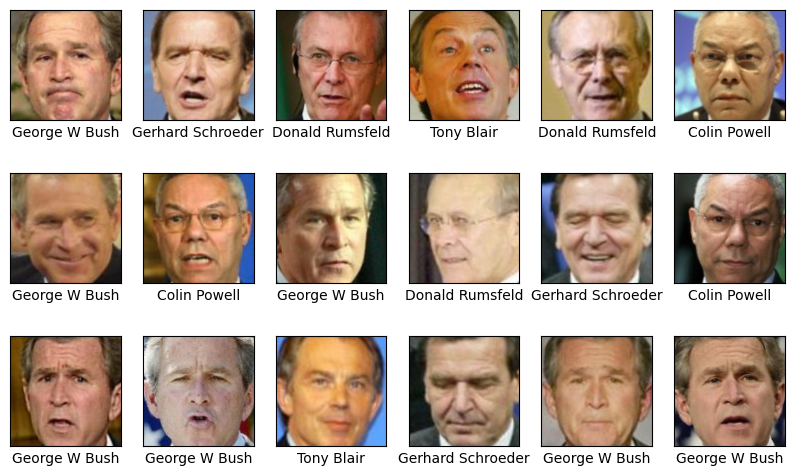

In [3]:
# show some images
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(3, 6, figsize=(10, 6))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i])
    axi.set(xticks=[], yticks=[], xlabel=faces.target_names[faces.target[i]])

In [4]:
# reduce dataset to 100 of each person
import numpy as np
mask = np.zeros(faces.target.shape, dtype=bool)

for target in np.unique(faces.target):
    mask[np.where(faces.target == target)[0][:100]] = 1

x_faces = faces.data[mask]
y_faces = faces.target[mask]
x_faces = np.reshape(x_faces, (x_faces.shape[0], faces.images.shape[1], faces.images.shape[2], faces.images.shape[3]))
x_faces.shape

(500, 128, 128, 3)

In [5]:
# preprocess and split dataset

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input

face_images = preprocess_input(np.array(x_faces*255))

x_train, x_test, y_train, y_test = train_test_split(face_images, y_faces, train_size=0.2, random_state=0, stratify=y_faces)


In [6]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
base_model.trainable = False # freeze the feature extration layer of ResNet50 so its weights are not updated during training

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Resizing

model = Sequential()
model.add(Resizing(224, 224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(class_count, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


2025-12-24 11:38:32.128311: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-12-24 11:38:32.128379: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-24 11:38:32.128383: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-12-24 11:38:32.128427: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-24 11:38:32.128441: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2025-12-24 11:38:35.249159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 871ms/step - accuracy: 0.2700 - loss: 226.7116 - val_accuracy: 0.5250 - val_loss: 47.5177
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 445ms/step - accuracy: 0.7000 - loss: 39.7813 - val_accuracy: 0.6100 - val_loss: 38.1321
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 453ms/step - accuracy: 0.8700 - loss: 8.3798 - val_accuracy: 0.6175 - val_loss: 38.5631
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 459ms/step - accuracy: 0.9700 - loss: 2.0014 - val_accuracy: 0.6100 - val_loss: 55.7304
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 460ms/step - accuracy: 0.9700 - loss: 2.5041 - val_accuracy: 0.6050 - val_loss: 46.4498
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 443ms/step - accuracy: 0.9700 - loss: 0.7086 - val_accuracy: 0.6775 - val_loss: 30.6592
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 480ms/step - accuracy: 0.9800 - loss: 0.4771 - val_accuracy: 0.6700 - val_loss: 29.8173
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 478ms/step - accuracy: 0.9900 - loss: 0.0192 - val_accuracy: 0.

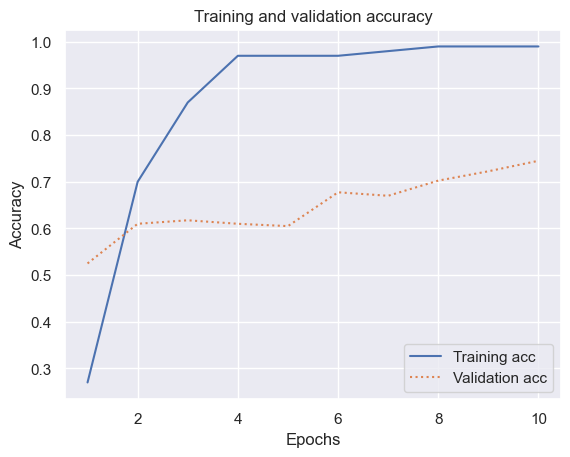

In [7]:
# Plot training and validation accuracy
import seaborn as sns
sns.set_theme()

hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=10)

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training acc')
plt.plot(epochs, val_acc, ':', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Boosting Transfer Learning with Task-Specific Weights   

In [8]:
from tensorflow.keras.models import load_model
base_model = load_model('Data/vggface.h5')
base_model.trainable = False

model = Sequential()
model.add(Resizing(224, 224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(class_count, activation="softmax"))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

TypeError: Error when deserializing class 'Conv2D' using config={'name': 'conv1/7x7_s2', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [7, 7], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}.

Exception encountered: Argument `name` must be a string and cannot contain character `/`. Received: name=conv1/7x7_s2 (of type <class 'str'>)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2900 - loss: 232.5429 - val_accuracy: 0.4575 - val_loss: 107.3002
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 513ms/step - accuracy: 0.6800 - loss: 45.4080 - val_accuracy: 0.6100 - val_loss: 42.0801
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 517ms/step - accuracy: 0.8800 - loss: 9.7201 - val_accuracy: 0.4675 - val_loss: 88.9504
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 519ms/step - accuracy: 0.9500 - loss: 5.8162 - val_accuracy: 0.7200 - val_loss: 27.9804
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 479ms/step - accuracy: 0.9400 - loss: 5.7477 - val_accuracy: 0.7900 - val_loss: 16.2716
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 477ms/step - accuracy: 0.9800 - loss: 1.3797 - val_accuracy: 0.7225 - val_loss: 25.0788
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 516ms/step - accuracy: 0.9900 - loss: 0.4098 - val_accuracy: 0.7625 - val_loss: 18.9054
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 486ms/step - accuracy: 1.0000 - loss: 5.9960e-07 - val

[]

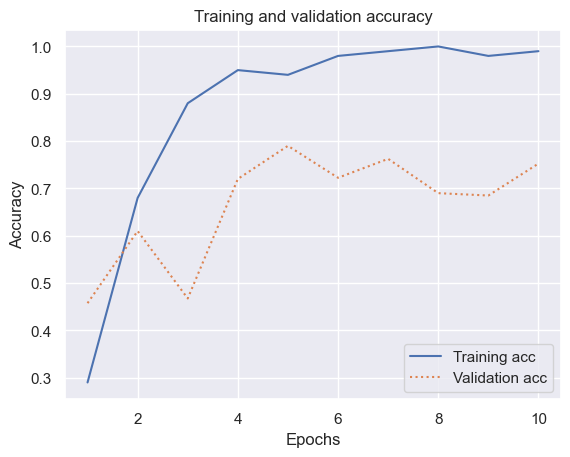

In [ ]:
# train the model
hist = model.fit(x_train, y_train, epochs=10, batch_size=10, validation_data=(x_test, y_test))
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training acc')
plt.plot(epochs, val_acc, ':', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 892ms/step


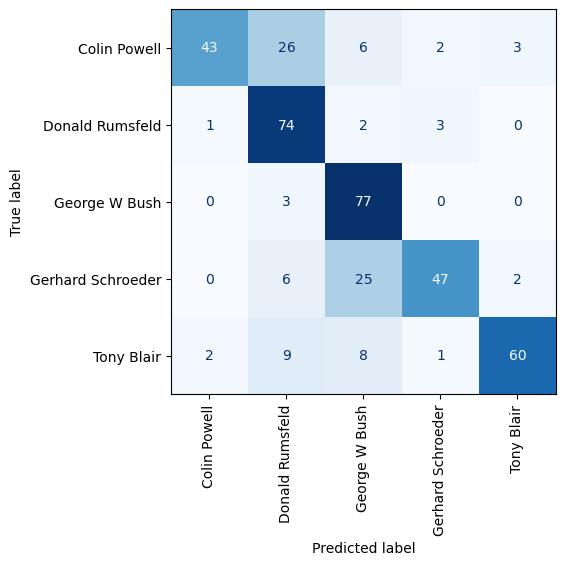

In [ ]:
# Assess results using a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay as cmd
sns.reset_orig()
y_pred = model.predict(x_test)
fig, ax = plt.subplots(figsize=(5, 5))
ax.grid(False)

cmd.from_predictions(y_test, y_pred.argmax(axis=1), display_labels=faces.target_names, colorbar=False, ax=ax, cmap='Blues', xticks_rotation='vertical')

